# Neural Style Transfer
**Выполнили: Терентьев Е. Д и Попов Д. П**


**Алгоритм нейронного переноса стиля** (англ. Neural Style Transfer, NST), разработанный Леоном Гатисом, Александром Экером и Матиасом Бетге, преобразует полученное на вход изображение в соответствии с выбранным стилем. 

Более подробную информацию можно прочитать в официальной [статье](https://www.researchgate.net/publication/281312423_A_Neural_Algorithm_of_Artistic_Style)


Алгоритм берет два изображения:

1)*Изображение контента* (англ. Content Image), в котором нас интересует содержание. Обычно оно является фотографией.

2)*Изображение стиля* (англ. Style Image), в котором нас интересует художественный стиль (цветовое наполнение, текстуры и т.д.). Обычно изображением стиля являются картины известных художников.

Затем алгоритм изменяет входные данные так, чтобы они соответствовали содержанию изображения контента и художественному стилю изображения стиля. Авторами в качестве модели сверточной нейронной сети предлагается использовать сеть VGG16/VGG19.

Пример того, что должно получиться. (Данный пример взят из статьи A Neural Algorithm of Artistic Style - Leon A. Gatys, Alexander S. Ecker, Matthias Bethge)

На изображение А -  исходная картинка, которую мы хотим стилизовать
На изображение B - финальное стилизованное изображение

![title](sources/Gatys_pics_example.png)

**Общая идея такова:**
Мы берем исходное изображение и рассматриваем его отдельные пиксели как настраиваемые параметры алгоритма градиентного спуска, а критерий качества должен быть выбран так, чтобы он уменьшался по мере приблежения исходного изображения к желаемому стилизованному 

В данном случае мы будем использовать сверточную нейронную сеть для получения критерия качества - т.е насколько близко наше исходное изображение к желаемому стилизованному.

**Критерий качества делится на:** 

- степень соответствия преобразованного изображения исходному
- степень стилизации преобразованного изображения

Для нахождения ***степени соответствия преобразованного изображения исходному*** будет как раз использоваться обученная сверточная нейронная сеть VGG19, которая в свою очередь уже с обученными весами связей, которые были получены по базе изображений ImageNet с 10млн изображений. Используем последний слой этой сети conv5_2, т.к он отвечает за набор общих признаков, и будем вычислять рассогласование между исходным изображением и преобразованным

Для нахождения ***степени стилизации преобразованного изображения***, нужно прогнать наше изображение стиля через VGG19 и возьмем предпоследний тензор(conv5_1) и преобразуем этот тензор в матрицу грама (она будет характеризовать схожесть признаков между каналами) - это будет характеристика стиля на текущем слое. Затем прогоняем через нейронную сеть формируемое изображение и получаем на conv5_1 уже другой тензор, с этим тензором выполняем такие же операции. И далее мы находим рассогласования между этими двумя матрицами


**Немного о VGG19**:
Архитектура представлена на данном рисунке:
![title](sources/VGG19_structure_.png)
архитектура состоит из:
- 19 слоев, 3 из них это слои полносвязной нейронной сети на конце нашей сети
- операция Maxpooling между слоями, которая увеличивает масштаб и отбирает наибольшие значения

***Создание проекта***

Импортируем нужные нам библиотеки:

In [2]:
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np



Загружаю контент-изображение(исходное для преобразования) и изображение со стилем, а также отображаю их:

Content Image:


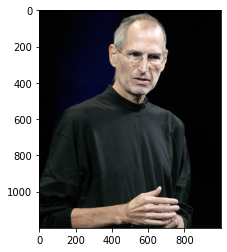

Style Image:


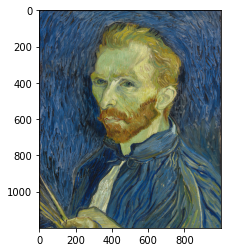

In [3]:
contentImage = Image.open("sources_images\source5.jpg") #best: source 2, style 3 ; AND 5;5
styleImage = Image.open("sources_images\style5.jpg")
print("Content Image:")
plt.imshow(contentImage)
plt.show()
print("Style Image:")
plt.imshow(styleImage)
plt.show()

Для того чтобы нейронная сеть смогла считать наше изображение нужно применить встроенную функцию в VGG19 preprocess_input, которая преобразует наше изображение формата RGB в BGR и кроме того ее компаненты смещены на некоторые значения, которые ниже будут описаны в коде, при возврате из BGR в RGB, а также добавить в нашу матрицу первую пространственную ось, потому что функция принимает в таком формате: batch, row, column, channels:

In [4]:
preprocess_cont_img = keras.applications.vgg19.preprocess_input(np.expand_dims(contentImage, axis=0))
preprocess_style_img = keras.applications.vgg19.preprocess_input(np.expand_dims(styleImage, axis=0))

Загружаем нейронную сеть VGG19: не используем полносвязную нейронную сеть на ее конце, веса предобученные по коллекции imagenet, а также указываем, что нельзя менять веса.

In [5]:
vgg = keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False 

Записываю в переменную название слоев сети VGG19, которые будут служить выходами для нашей новой сети:

In [6]:
content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1'] #использую 5 слоев, так как у стиля разные степени абстракции
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Нахожу и записываю в переменные нужные мне слои в нейронной сети VGG19 и затем объединяю и вывожу их (слои выходов (outputs))

In [7]:
style_outputs = [vgg.get_layer(name).output for name in style_layers] #ищу слои по названию из style_layers в VGG и закидываю в переменную для того, чтобы получить выход на этом слое(output)
content_outputs = [vgg.get_layer(name).output for name in content_layers] #ищу слои по названию из content_layers в VGG и закидываю в переменную для того, чтобы получить выход на этом слое(output)
model_outputs = style_outputs + content_outputs #соединяю два списка для общих Outputs

print(vgg.input) #вывожу инпут layer VGG
for m in model_outputs: #вывожу outputs полученные из сети
    print(m)

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='block3_conv1/Relu:0', description="created by layer 'block3_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block4_conv1/Relu:0', description="created by layer 'block4_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block5_conv1/Relu:0', description="created by layer 'block5_conv1'")
K

Создаю новую модель, у которой 1 вход и множество выходов, которые я указал раннее в переменной(model_outputs):

In [8]:
model = keras.models.Model(vgg.input, model_outputs) #создаю модель на основе VGG, задавая input как VGG, а Output те, которые определил раннее
for layer in model.layers:
    layer.trainable = False #NONtrainable

print(model.summary()) #вывожу архитектуру

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Функция для возвращение в формат RGB из BGR:

In [9]:
def FromBGRtoRGB(inputImage):
    averageValues = [103.939, 116.779, 123.68]
    imageCopy = inputImage.copy()
    imageCopy = np.squeeze(imageCopy, 0)
    #убираю усреднение 
    imageCopy[..., 0] += averageValues[0] 
    imageCopy[..., 1] += averageValues[1]
    imageCopy[..., 2] += averageValues[2]
    imageCopy = imageCopy[..., ::-1] #перевожу BGR -> RGB

    imageCopy = np.clip(imageCopy, 0, 255).astype('uint8') # откидываю все что больше 255 и меньше 0
    return imageCopy

Функция которая возвращает карты признаков для стиля и для контента:

In [10]:
def get_feature_representations(model):
    # пропускаю через нейронку изображения
    style_outputs = model(preprocess_style_img)
    content_outputs = model(preprocess_cont_img)
    # получаю карты признаков на выбранных выходах 
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

Функция для определения рассогласования по контенту - насколько контент-изображение отличается от полученного стилизованного (насколько основной контент сохранился на стилизованном). Для этого мы используем следующую формулу
![title](sources/get_content_loss.png)

In [11]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

Чтобы получить числовые характеристики по стилю на каждом из слоев - нам нужен тензер(кол-во строк, кол-во столбцов, кол-во каналов(карт признаков)), превратить в *матрицу Грама*. (Это предложил Л.Гатис)
Матрица грама представляет собой след структуру:
![title](sources/gram_matrix.png)

In [12]:
def gram_matrix(input_tensor):
    cnt_channels = int(input_tensor.shape[-1]) #нахождение кол-во каналов
    reshapedMatrix = tf.reshape(input_tensor, [-1, cnt_channels]) # преобразуем наш тензер в двумерный(матрицу)
    n = tf.shape(reshapedMatrix)[0] #кол-во строк полученной матрицы (произведение первых величин(кол-во строк * кол-во столбцов исходного тензора, каждого слоя))
    gram = tf.matmul(reshapedMatrix, reshapedMatrix, transpose_a=True) # перемножение матрицы на транспонированную матрицу
    return gram / tf.cast(n, tf.float32) # делим на кол-во строк, чтобы усреднить значения (tf.cast - преобразование типа)

Функция вычисления рассогласования по стилю для 5 разных сверточных нейронных слоев, применяем данную формулу для вычисления:
![title](sources/get_style_loss.png)

In [13]:
def get_style_loss(base_style, gram_target):
    return tf.reduce_mean(tf.square(gram_matrix(base_style) - gram_target))

**Общие потери** мы будет находить по данной формуле:
Рис.1:
![title](sources/total_losses.png)
Рис.2:
![title](sources/general_style_loss.png)

In [19]:
def calculate_total_loss(model, loss_weights, init_image, gram_style_features, content_features): #(рис.1)
    model_outputs = model(init_image) #пропускаем формируемое изображение через нейронную сеть и получаем значения на каждом нужном сверточном слое
    style_output_features = model_outputs[:num_style_layers] #выделяем из Model_outputs карты признаков для стиля
    content_output_features = model_outputs[num_style_layers:] #выделяем из Model_outputs карты признаков для контента
    #передаем модель; два параметра a,b; формируемое изображение;
    weights_for_style, weights_for_content = loss_weights # наши параметры a, b
    #вспомогательные величины для потерь по: стилю и контенту
    style_assessment = 0
    content_assessment = 0

    # собираю потери стиля со всех слоев (рис.2)
    weight_per_style_layer = 1.0 / float(num_style_layers) #определяю веса для суммирования потерь стилей каждого слоя
    #на каждом слое нахожу потери по стилю и суммирую их умножения на weight_per_style_layer
    for target_style, comb_style in zip(gram_style_features, style_output_features):  # перебираем матрицы грама стилевого изображения и карты признаков 
        style_assessment += weight_per_style_layer * get_style_loss(comb_style[0], target_style) #суммируем квадраты рассогласований чтобы получить со всех слоев
    style_assessment *= weights_for_style #умножение на коэф

    # собираю потери по контенту со всех слоев
    weight_per_content_layer = 1.0 / float(num_content_layers)
    #на каждом слое нахожу потери по контенту и суммирую их умножения на weight_per_content_layer
    for target_content, comb_content in zip(content_features, content_output_features):
        content_assessment += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
    content_assessment *= weights_for_content #умножение на коэф

    total_losses = style_assessment + content_assessment #общие потери
    return total_losses, style_assessment, content_assessment

Задаю переменные для дальнейшего использования:

In [21]:
num_iterations=100 #кол-во итераций
content_weight=1000 #насколько важен нам контент на формируемом изображении (параметр a) 
style_weight=0.1 #насколько важен нам стиль на формируемом изображении (параметр b) 
#пропускаем наши изображения через нейронку и получаем карты признаков по контенту и стилю:
style_features, content_features = get_feature_representations(model)
#вычисляю матрицу грама для изображений со стилями
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

init_image = np.copy(preprocess_cont_img) #копирую начальное изображение(контентное)
init_image = tf.Variable(init_image, dtype=tf.float32) #переделываю ее в переменную, которую понимает tf

best_loss = float('inf') #наименьшие потери
best_img = None #наилучшее изображение
loss_weights = (style_weight, content_weight) #loss_weight из параметров: b, a
imgs = [] #список в который будут добавляться изображения при условии if loss < best_loss

Запуск алгоритма **градиентного спуска**, который будет менять исходное изображение так, чтобы минимизировать показатель качества (total_loss)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


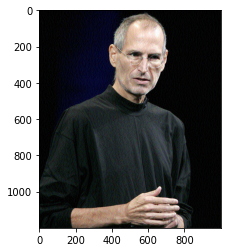

In [22]:
# создаю оптимизатор для градиентного спуска Adam — adaptive moment estimation
opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)

#Запуск алгоритма градиентного спуска - формирования стилизованного изображения
for i in range(num_iterations):
    with tf.GradientTape() as tape: 
        all_losses = calculate_total_loss(model, loss_weights, init_image, gram_style_features, content_features) #вызываем функцию в области видимости tf.GradientTape 
    
    loss, style_assessment, content_assessment = all_losses
    calculate_gradients = tape.gradient(loss, init_image) #вычисляем градиент, передаю: 1арг - функция, в данном случае наши потери, 2арг - аргументы, от которых вычислим частные производные (изначальное изображение)
    opt.apply_gradients([(calculate_gradients, init_image)]) #применяем вычисленный градиент к пикселям нашего изображения
    
    if loss < best_loss:
        #Ищу лучшее изображение по минимальной потери. 
        best_loss = loss
        best_img = FromBGRtoRGB(init_image.numpy())
        imgs.append(best_img)
        print('Iteration: {}'.format(i))

plt.imshow(best_img)
image = Image.fromarray(best_img.astype('uint8'), 'RGB')
image.save('results/result8.jpg')

#for elem in imgs:
    #plt.imshow(elem)
    #plt.show()
